In [2]:
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates

In [4]:
weather_data = pd.read_csv('../../data/Plant_1_Weather_Sensor_Data.csv')
gen_data = pd.read_csv('../../data/Plant_1_Generation_Data.csv')
weather_data['DATE_TIME']= pd.to_datetime(weather_data['DATE_TIME'])
gen_data['DATE_TIME']= pd.to_datetime(gen_data['DATE_TIME'])

In [6]:
weather_data['DAY'] = pd.DatetimeIndex(weather_data['DATE_TIME']).dayofyear
weather_data['TIME'] = weather_data.DATE_TIME.dt.hour * 60 + weather_data.DATE_TIME.dt.minute
weather_data['HOUR'] = weather_data.DATE_TIME.dt.hour
weather_data['Time'] =weather_data.DATE_TIME.dt.time
weather_data['DATE'] =weather_data.DATE_TIME.dt.date
weather_data.head()

DATE_TIME  PLANT_ID       SOURCE_KEY  AMBIENT_TEMPERATURE  \
0 2020-05-15 00:00:00   4135001  HmiyD2TTLFNqkNe            25.184316   
1 2020-05-15 00:15:00   4135001  HmiyD2TTLFNqkNe            25.084589   
2 2020-05-15 00:30:00   4135001  HmiyD2TTLFNqkNe            24.935753   
3 2020-05-15 00:45:00   4135001  HmiyD2TTLFNqkNe            24.846130   
4 2020-05-15 01:00:00   4135001  HmiyD2TTLFNqkNe            24.621525   

   MODULE_TEMPERATURE  IRRADIATION  DAY  TIME  HOUR      Time        DATE  
0           22.857507          0.0  136     0     0  00:00:00  2020-05-15  
1           22.761668          0.0  136    15     0  00:15:00  2020-05-15  
2           22.592306          0.0  136    30     0  00:30:00  2020-05-15  
3           22.360852          0.0  136    45     0  00:45:00  2020-05-15  
4           22.165423          0.0  136    60     1  01:00:00  2020-05-15

In [8]:
gen_data['DAY'] = pd.DatetimeIndex(gen_data['DATE_TIME']).dayofyear
gen_data['TIME'] = gen_data.DATE_TIME.dt.hour * 60 + weather_data.DATE_TIME.dt.minute
gen_data['HOUR'] = gen_data.DATE_TIME.dt.hour
gen_data['Time'] =gen_data.DATE_TIME.dt.time
gen_data['DATE'] =gen_data.DATE_TIME.dt.date
gen_data.head()

DATE_TIME  PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  \
0 2020-05-15   4135001  1BY6WEcLGh8j5v7       0.0       0.0          0.0   
1 2020-05-15   4135001  1IF53ai7Xc0U56Y       0.0       0.0          0.0   
2 2020-05-15   4135001  3PZuoBAID5Wc2HD       0.0       0.0          0.0   
3 2020-05-15   4135001  7JYdWkrLSPkdwr4       0.0       0.0          0.0   
4 2020-05-15   4135001  McdE0feGgRqW7Ca       0.0       0.0          0.0   

   TOTAL_YIELD  DAY  TIME  HOUR      Time        DATE  
0    6259559.0  136   0.0     0  00:00:00  2020-05-15  
1    6183645.0  136  15.0     0  00:00:00  2020-05-15  
2    6987759.0  136  30.0     0  00:00:00  2020-05-15  
3    7602960.0  136  45.0     0  00:00:00  2020-05-15  
4    7158964.0  136   0.0     0  00:00:00  2020-05-15

## Cloudiness

In [9]:
#Hourly maximum irradiation, module and ambient temp
agg_h_irr = weather_data.groupby(weather_data.TIME).agg({'IRRADIATION': 'max',
                                                            'MODULE_TEMPERATURE': 'max',
                                                            'AMBIENT_TEMPERATURE': 'max'})
agg_h_irr.head()

IRRADIATION  MODULE_TEMPERATURE  AMBIENT_TEMPERATURE
TIME                                                      
0             0.0           22.857507            25.184316
15            0.0           22.761668            25.084589
30            0.0           22.666227            24.935753
45            0.0           22.743333            24.846130
60            0.0           22.723669            24.621525

In [12]:
from sklearn.neighbors import NearestNeighbors
neighbour_number=10
outlier_limit=10
#Removing outliers from the max curve
clean_data=agg_h_irr.copy().reset_index()
X=clean_data[['TIME', 'IRRADIATION']]
nbrs = NearestNeighbors(n_neighbors=neighbour_number).fit(X)
distances, indices = nbrs.kneighbors(X)
distance=pd.DataFrame(distances).loc[:, 1:].mean(axis=1)
outlier_condition=distance>distance.mean()+outlier_limit*distance.std()
clean_data.drop(distance[outlier_condition].index, inplace=True)
agg_h_irr_clean = clean_data.groupby(clean_data.TIME).agg({'IRRADIATION': 'max'})
agg_h_irr_clean.head()

IRRADIATION
TIME             
0             0.0
15            0.0
30            0.0
45            0.0
60            0.0

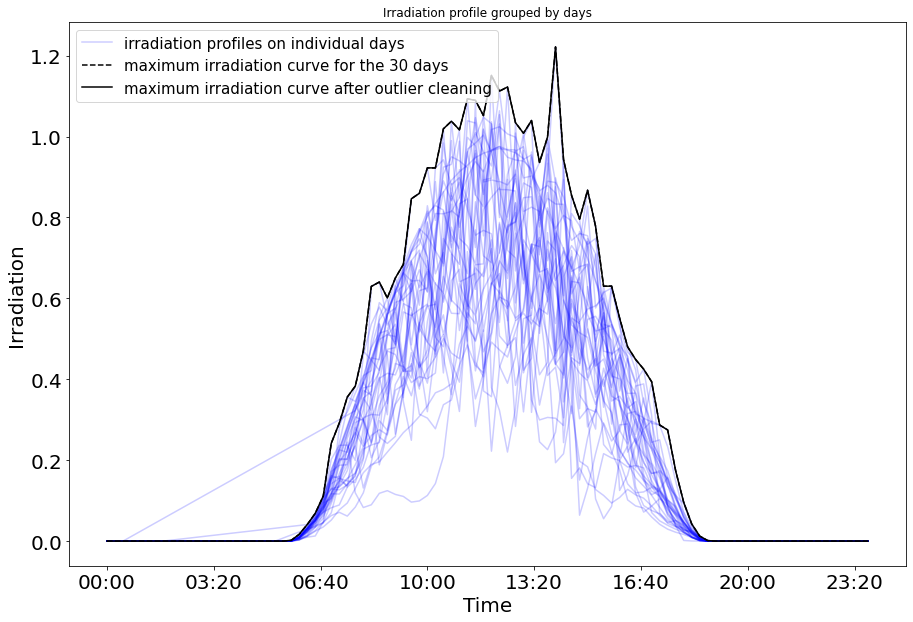

In [15]:
ax=plt.figure(figsize=(15, 10))
for a, b in weather_data.groupby(weather_data['DAY']):
    if a==136:
        plt.plot(b['TIME'], b['IRRADIATION'], 'b-', alpha=0.2, label="irradiation profiles on individual days")
    else:
    #plt.plot_date(mdates.datestr2num(b['Time'].apply(lambda x: x.strftime('%d%m%Y'))), b['IRRADIATION'])
        plt.plot(b['TIME'], b['IRRADIATION'], 'b-', alpha=0.2)
plt.plot(agg_h_irr.index, agg_h_irr['IRRADIATION'], 'k--', label="maximum irradiation curve for the 30 days")
plt.plot(agg_h_irr_clean.index, agg_h_irr_clean['IRRADIATION'], 'k-', label="maximum irradiation curve after outlier cleaning")

plt.ylabel('Irradiation', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.title('Irradiation profile grouped by days')
locs, labels = plt.xticks()
labels=[]
for loc in locs[1:-1]:
    hour=int(loc/60)
    minute=int(loc-hour*60)
    string=str(hour)+"-"+str(minute)
    labels.append(datetime.strptime(string, "%H-%M").strftime('%H:%M'))
plt.xticks(locs[1:-1], labels, fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)

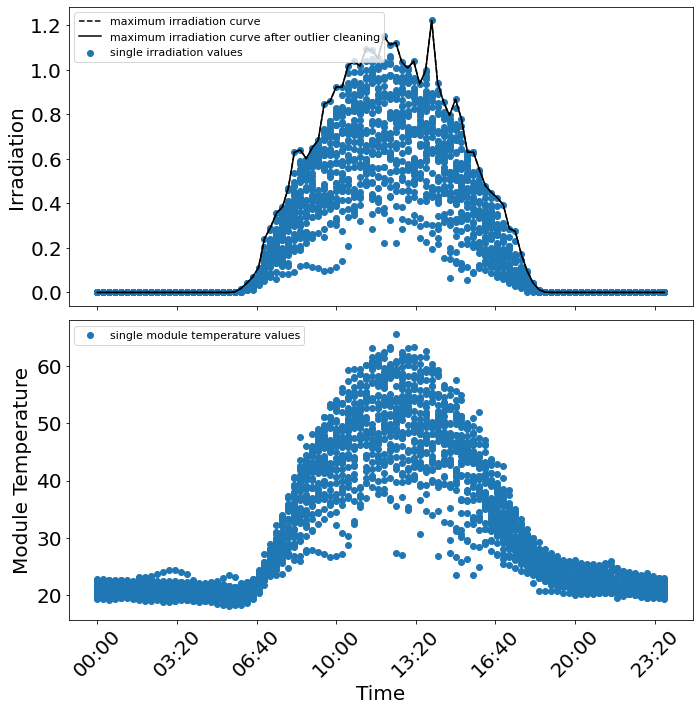

In [16]:
fig, ax = plt.subplots(2,1, figsize=(10, 10), sharex=True)
# plt.plot(C_day_max.TIME,C_day_max.IRRADIATION,'r', label="cloudy", alpha=0.8)
ax[0].scatter(weather_data['TIME'], weather_data['IRRADIATION'], label="single irradiation values")
ax[0].plot(agg_h_irr.index, agg_h_irr['IRRADIATION'], 'k--', label="maximum irradiation curve")
ax[0].plot(agg_h_irr_clean.index, agg_h_irr_clean['IRRADIATION'], 'k-', label="maximum irradiation curve after outlier cleaning")

ax[1].scatter(weather_data['TIME'], weather_data['MODULE_TEMPERATURE'], label="single module temperature values")

ax[1].set_xlabel('Time', fontsize=20)
ax[1].set_ylabel('Module Temperature', fontsize=20)
ax[0].set_ylabel('Irradiation', fontsize=20)
locs, labels = plt.xticks()
labels=[]
for loc in locs[1:-1]:
    hour=int(loc/60)
    minute=int(loc-hour*60)
    string=str(hour)+"-"+str(minute)
    labels.append(datetime.strptime(string, "%H-%M").strftime('%H:%M'))
plt.xticks(locs[1:-1], labels, rotation=45)
ax[1].tick_params(labelsize=20)
ax[0].tick_params(labelsize=20)
ax[0].legend(loc="upper left", fontsize=11)
ax[1].legend(loc="upper left", fontsize=11)

plt.tight_layout()

In [19]:
weather_maxirr = pd.merge(weather_data, agg_h_irr, how='inner', on='TIME', suffixes=('', '_max'))
weather_maxirr['irradiation_offset_from_max']=(weather_maxirr['IRRADIATION_max']-weather_maxirr['IRRADIATION'])**2.
C_day_list=weather_maxirr.groupby('DAY').sum()['irradiation_offset_from_max']
weather_maxirr = pd.merge(weather_maxirr, C_day_list, how='inner', on='DAY')
weather_maxirr_new = weather_maxirr.rename(columns={'irradiation_offset_from_max_y': 'C_day', 'irradiation_offset_from_max_x': 'irradiation_offset_from_max'})
weather_maxirr_new.head()

DATE_TIME  PLANT_ID       SOURCE_KEY  AMBIENT_TEMPERATURE  \
0 2020-05-15 00:00:00   4135001  HmiyD2TTLFNqkNe            25.184316   
1 2020-05-15 00:15:00   4135001  HmiyD2TTLFNqkNe            25.084589   
2 2020-05-15 00:30:00   4135001  HmiyD2TTLFNqkNe            24.935753   
3 2020-05-15 00:45:00   4135001  HmiyD2TTLFNqkNe            24.846130   
4 2020-05-15 01:00:00   4135001  HmiyD2TTLFNqkNe            24.621525   

   MODULE_TEMPERATURE  IRRADIATION  DAY  TIME  HOUR      Time        DATE  \
0           22.857507          0.0  136     0     0  00:00:00  2020-05-15   
1           22.761668          0.0  136    15     0  00:15:00  2020-05-15   
2           22.592306          0.0  136    30     0  00:30:00  2020-05-15   
3           22.360852          0.0  136    45     0  00:45:00  2020-05-15   
4           22.165423          0.0  136    60     1  01:00:00  2020-05-15   

   IRRADIATION_max  MODULE_TEMPERATURE_max  AMBIENT_TEMPERATURE_max  \
0              0.0               22.857507                25.184316   
1              0.0               22.761668                25.084589   
2              0.0               22.666227                24.935753   
3              0.0               22.743333                24.846130   
4              0.0               22.723669                24.621525   

   irradiation_offset_from_max     C_day  
0                          0.0  5.856702  
1                          0.0  5.856702  
2                          0.0  5.856702  
3                          0.0  5.856702  
4                          0.0  5.856702

In [20]:
irr_c = []
for a, b in weather_maxirr.groupby(weather_maxirr['DAY']):
    c = b['IRRADIATION'].corr(b['IRRADIATION_max'])
    irr_c.append(c)

irr_corr = pd.DataFrame(data=np.array(irr_c), columns=['CORRELATION'])
irr_corr['DAY'] = weather_data['DAY'].unique()
weather_and_corr=pd.merge(weather_maxirr,irr_corr, how='inner', on='DAY')
weather_and_corr.head()

DATE_TIME  PLANT_ID       SOURCE_KEY  AMBIENT_TEMPERATURE  \
0 2020-05-15 00:00:00   4135001  HmiyD2TTLFNqkNe            25.184316   
1 2020-05-15 00:15:00   4135001  HmiyD2TTLFNqkNe            25.084589   
2 2020-05-15 00:30:00   4135001  HmiyD2TTLFNqkNe            24.935753   
3 2020-05-15 00:45:00   4135001  HmiyD2TTLFNqkNe            24.846130   
4 2020-05-15 01:00:00   4135001  HmiyD2TTLFNqkNe            24.621525   

   MODULE_TEMPERATURE  IRRADIATION  DAY  TIME  HOUR      Time        DATE  \
0           22.857507          0.0  136     0     0  00:00:00  2020-05-15   
1           22.761668          0.0  136    15     0  00:15:00  2020-05-15   
2           22.592306          0.0  136    30     0  00:30:00  2020-05-15   
3           22.360852          0.0  136    45     0  00:45:00  2020-05-15   
4           22.165423          0.0  136    60     1  01:00:00  2020-05-15   

   IRRADIATION_max  MODULE_TEMPERATURE_max  AMBIENT_TEMPERATURE_max  \
0              0.0               22.857507                25.184316   
1              0.0               22.761668                25.084589   
2              0.0               22.666227                24.935753   
3              0.0               22.743333                24.846130   
4              0.0               22.723669                24.621525   

   irradiation_offset_from_max_x  irradiation_offset_from_max_y  CORRELATION  
0                            0.0                       5.856702     0.949892  
1                            0.0                       5.856702     0.949892  
2                            0.0                       5.856702     0.949892  
3                            0.0                       5.856702     0.949892  
4                            0.0                       5.856702     0.949892

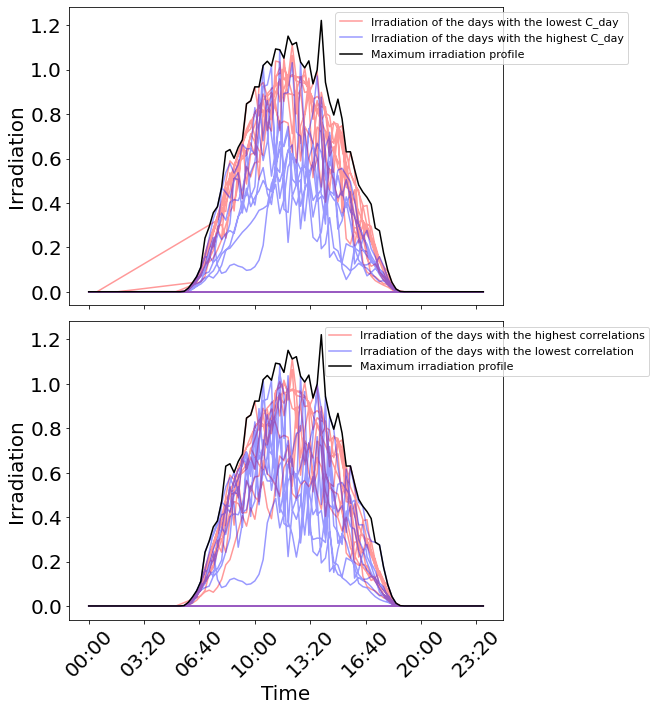

In [24]:
fig, ax = plt.subplots(2,1, figsize=(10, 10), sharex=True)
C_day_min=weather_maxirr_new[weather_maxirr_new.C_day<2.5]
C_day_max=weather_maxirr_new[weather_maxirr_new.C_day>6.2]
weather_maxirr_new['Time'] =weather_maxirr_new.DATE_TIME.dt.time
corr_max=weather_and_corr[weather_and_corr.CORRELATION>0.97]
corr_min=weather_and_corr[weather_and_corr.CORRELATION<0.912]
weather_and_corr['Time'] =weather_and_corr.DATE_TIME.dt.time
# plt.plot(C_day_max.TIME,C_day_max.IRRADIATION,'r', label="cloudy", alpha=0.8)
ax[0].plot(C_day_min.TIME,C_day_min.IRRADIATION,'r', alpha=0.4, label='Irradiation of the days with the lowest C_day')
ax[0].plot(C_day_max.TIME,C_day_max.IRRADIATION,'b', alpha=0.4, label='Irradiation of the days with the highest C_day')
#ax[1].plot(corr_max.TIME,corr_max.IRRADIATION_max,'black',label="Hourly maximum irradiation")
ax[1].plot(corr_max.TIME,corr_max.IRRADIATION,'r', alpha=0.4, label='Irradiation of the days with the highest correlations')
ax[1].plot(corr_min.TIME,corr_min.IRRADIATION,'b', alpha=0.4, label='Irradiation of the days with the lowest correlation')
ax[0].plot(agg_h_irr_clean.index,agg_h_irr_clean['IRRADIATION'],'black',label="Maximum irradiation profile")
ax[1].plot(agg_h_irr_clean.index,agg_h_irr_clean['IRRADIATION'],'black',label="Maximum irradiation profile")
ax[1].set_xlabel('Time', fontsize=20)
ax[1].set_ylabel('Irradiation', fontsize=20)
ax[0].set_ylabel('Irradiation', fontsize=20)
locs, labels = plt.xticks()
labels=[]
for loc in locs[1:-1]:
    hour=int(loc/60)
    minute=int(loc-hour*60)
    string=str(hour)+"-"+str(minute)
    labels.append(datetime.strptime(string, "%H-%M").strftime('%H:%M'))
plt.xticks(locs[1:-1], labels, rotation=45)
ax[1].tick_params(labelsize=20)
ax[0].tick_params(labelsize=20)
ax[0].legend(loc="upper right", bbox_to_anchor=(1.3,  1), fontsize=11)
ax[1].legend(loc="upper right", bbox_to_anchor=(1.35,  1), fontsize=11)

plt.tight_layout()

## Efficiency

In [25]:
merged_df = pd.merge(gen_data, weather_data, how='inner', on=['DATE_TIME'], suffixes=('', '_y'))
merged_df

DATE_TIME  PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  \
0     2020-05-15 00:00:00   4135001  1BY6WEcLGh8j5v7       0.0       0.0   
1     2020-05-15 00:00:00   4135001  1IF53ai7Xc0U56Y       0.0       0.0   
2     2020-05-15 00:00:00   4135001  3PZuoBAID5Wc2HD       0.0       0.0   
3     2020-05-15 00:00:00   4135001  7JYdWkrLSPkdwr4       0.0       0.0   
4     2020-05-15 00:00:00   4135001  McdE0feGgRqW7Ca       0.0       0.0   
...                   ...       ...              ...       ...       ...   
68769 2020-06-17 23:45:00   4135001  uHbuxQJl8lW7ozc       0.0       0.0   
68770 2020-06-17 23:45:00   4135001  wCURE6d3bPkepu2       0.0       0.0   
68771 2020-06-17 23:45:00   4135001  z9Y9gH1T5YWrNuG       0.0       0.0   
68772 2020-06-17 23:45:00   4135001  zBIq5rxdHJRwDNY       0.0       0.0   
68773 2020-06-17 23:45:00   4135001  zVJPv84UY57bAof       0.0       0.0   

       DAILY_YIELD  TOTAL_YIELD  DAY  TIME  HOUR  ... PLANT_ID_y  \
0            0.000    6259559.0  136   0.0     0  ...    4135001   
1            0.000    6183645.0  136  15.0     0  ...    4135001   
2            0.000    6987759.0  136  30.0     0  ...    4135001   
3            0.000    7602960.0  136  45.0     0  ...    4135001   
4            0.000    7158964.0  136   0.0     0  ...    4135001   
...            ...          ...  ...   ...   ...  ...        ...   
68769     5967.000    7287002.0  169   NaN    23  ...    4135001   
68770     5147.625    7028601.0  169   NaN    23  ...    4135001   
68771     5819.000    7251204.0  169   NaN    23  ...    4135001   
68772     5817.000    6583369.0  169   NaN    23  ...    4135001   
68773     5910.000    7363272.0  169   NaN    23  ...    4135001   

          SOURCE_KEY_y  AMBIENT_TEMPERATURE MODULE_TEMPERATURE  IRRADIATION  \
0      HmiyD2TTLFNqkNe            25.184316          22.857507          0.0   
1      HmiyD2TTLFNqkNe            25.184316          22.857507          0.0   
2      HmiyD2TTLFNqkNe            25.184316          22.857507          0.0   
3      HmiyD2TTLFNqkNe            25.184316          22.857507          0.0   
4      HmiyD2TTLFNqkNe            25.184316          22.857507          0.0   
...                ...                  ...                ...          ...   
68769  HmiyD2TTLFNqkNe            21.909288          20.427972          0.0   
68770  HmiyD2TTLFNqkNe            21.909288          20.427972          0.0   
68771  HmiyD2TTLFNqkNe            21.909288          20.427972          0.0   
68772  HmiyD2TTLFNqkNe            21.909288          20.427972          0.0   
68773  HmiyD2TTLFNqkNe            21.909288          20.427972          0.0   

       DAY_y  TIME_y  HOUR_y    Time_y      DATE_y  
0        136       0       0  00:00:00  2020-05-15  
1        136       0       0  00:00:00  2020-05-15  
2        136       0       0  00:00:00  2020-05-15  
3        136       0       0  00:00:00  2020-05-15  
4        136       0       0  00:00:00  2020-05-15  
...      ...     ...     ...       ...         ...  
68769    169    1425      23  23:45:00  2020-06-17  
68770    169    1425      23  23:45:00  2020-06-17  
68771    169    1425      23  23:45:00  2020-06-17  
68772    169    1425      23  23:45:00  2020-06-17  
68773    169    1425      23  23:45:00  2020-06-17  

[68774 rows x 22 columns]

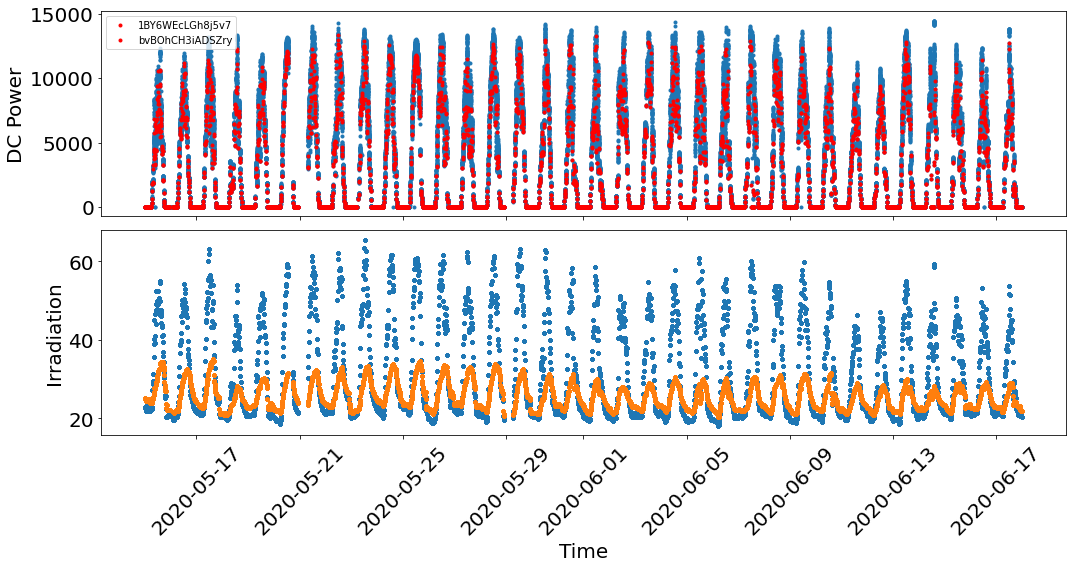

In [27]:
%matplotlib inline
plant=1
if plant==1:
    main_anomalous=["1BY6WEcLGh8j5v7", "bvBOhCH3iADSZry"]
if plant==2:
    main_anomalous=["Quc1TzYxW2pYoWX"]
data=merged_df
f, ax=plt.subplots(2,1, figsize=(15, 8), sharex=True)
ax[0].plot(data['DATE_TIME'], data['DC_POWER'], '.')
for inv in main_anomalous:
    ax[0].plot(data[data["SOURCE_KEY"]==inv]['DATE_TIME'], 
         data[data["SOURCE_KEY"]==inv]['DC_POWER'], 'r.', label=inv)
#ax[0].plot(data[data["SOURCE_KEY"]=="ih0vzX44oOqAx2f"]['DATE_TIME'], 
#         data[data["SOURCE_KEY"]=="ih0vzX44oOqAx2f"]['DC_POWER'], 'k.', label=inv)
#ax[0].plot(data[data["alarm_DC_conversion_outlier"]==1]['DATE_TIME'], 
#         data[data["alarm_DC_conversion_outlier"]==1]['DC_POWER'], 'rx', label="anomalous points")
ax[1].plot(data['DATE_TIME'], 
         data['MODULE_TEMPERATURE'], '.')
ax[1].plot(data['DATE_TIME'], 
         data['AMBIENT_TEMPERATURE'], '.')
#plt.plot(merged_ac_conv_out[merged_ac_conv_out["alarm_AC_conversion_outlier"]==1]['DATE_TIME'], 
#         merged_ac_conv_out[merged_ac_conv_out["alarm_AC_conversion_outlier"]==1]['ERROR'], 'gx')
plt.xticks(rotation=45)
ax[1].set_xlabel('Time', fontsize=20)
ax[0].set_ylabel('DC Power', fontsize=20)
ax[1].set_ylabel('Irradiation', fontsize=20)
ax[0].legend()
ax[0].tick_params(labelsize=20)
ax[1].tick_params(labelsize=20)
plt.tight_layout()

(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000., 12000.,
        14000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

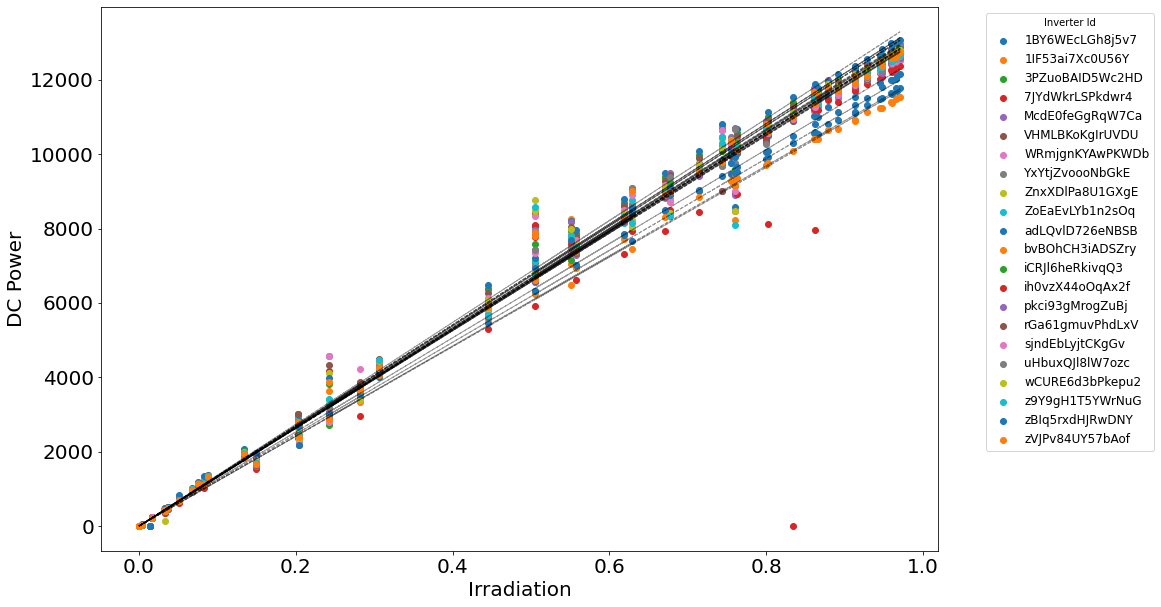

In [29]:
from sklearn.linear_model import LinearRegression
coeff=[]
inv0=merged_df[merged_df.DAY==146]
plt.figure(figsize=(15, 10))
for a, day in inv0.groupby(inv0.SOURCE_KEY):
    X = day['IRRADIATION'].values.reshape(-1,1)
    y = day['DC_POWER'].values.reshape(-1,1)
    regressor = LinearRegression(fit_intercept=False)
    plt.scatter(day['IRRADIATION'], day['DC_POWER'], label=a)
    regressor.fit(X, y)
    m=regressor.coef_
    result = []
    [result.extend(el) for el in m] 
    E=[]
    for el in result:
        E.append(el)
    plt.plot(day['IRRADIATION'], E*day['IRRADIATION'] , linewidth=1, color='k', linestyle='--', alpha=0.4)
    coeff.append(E)
    coefficients = pd.DataFrame(data=np.array(coeff), columns=['lin_fit_coeff'])
coefficients['DAY'] = merged_df['SOURCE_KEY'].unique()
plt.legend(title="Inverter Id", fontsize=12, bbox_to_anchor=(1.05, 1))
plt.xlabel('Irradiation', fontsize=20)
plt.ylabel('DC Power', fontsize=20)
#plt.title("Linear fit describing the efficiency of DC conversion of inverter 0 grouped by days")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [30]:
#Removing the outliers to have a better fit of the data
clean_data=merged_df.copy()
for i, j in  clean_data.groupby(clean_data.HOUR):
    outlier_condition1=j['DC_POWER']>=(j['DC_POWER'].mean()+ 3*j['DC_POWER'].std())
    outlier_condition2=j['DC_POWER']<(j['DC_POWER'].mean()- 3*j['DC_POWER'].std())
    clean_data.drop(clean_data.loc[(clean_data['DAY'].isin(j.loc[outlier_condition1|outlier_condition2].DAY))&(clean_data['HOUR']==i)].index, inplace=True)

(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000., 12000.,
        14000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

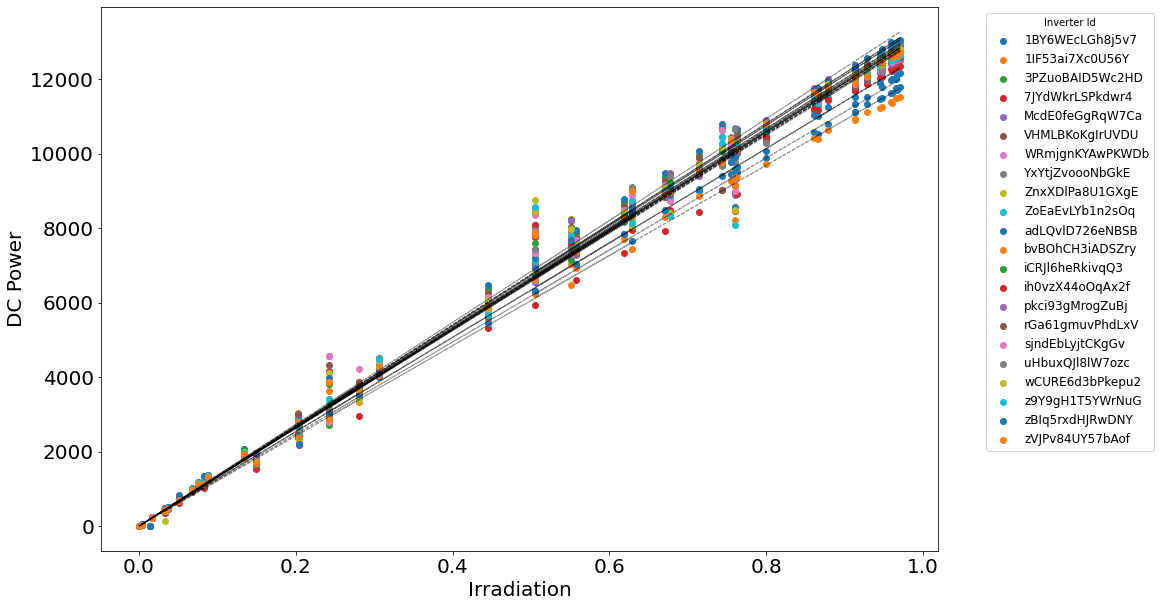

In [31]:
coeff=[]
inv0=clean_data[clean_data.DAY==146]
plt.figure(figsize=(15, 10))
for a, day in inv0.groupby(inv0.SOURCE_KEY):
    X = day['IRRADIATION'].values.reshape(-1,1)
    y = day['DC_POWER'].values.reshape(-1,1)
    regressor = LinearRegression(fit_intercept=False)
    plt.scatter(day['IRRADIATION'], day['DC_POWER'], label=a)
    regressor.fit(X, y)
    m=regressor.coef_
    result = []
    [result.extend(el) for el in m] 
    E=[]
    for el in result:
        E.append(el)
    plt.plot(day['IRRADIATION'], E*day['IRRADIATION'] , linewidth=1, color='k', linestyle='--', alpha=0.4)
    coeff.append(E)
    coefficients = pd.DataFrame(data=np.array(coeff), columns=['lin_fit_coeff'])
coefficients['DAY'] = merged_df['SOURCE_KEY'].unique()
plt.legend(title="Inverter Id", fontsize=12, bbox_to_anchor=(1.05, 1))
plt.xlabel('Irradiation', fontsize=20)
plt.ylabel('DC Power', fontsize=20)
#plt.title("Linear fit describing the efficiency of DC conversion of inverter 0 grouped by days")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [32]:
def find_cloudiness_v2(data, col_name, neighbour_number=10, outlier_limit=10):
    #Removing outliers from the max curve
    clean_data=data.copy()
    X=clean_data[['TIME', col_name]]
    nbrs = NearestNeighbors(n_neighbors=neighbour_number).fit(X)
    distances, indices = nbrs.kneighbors(X)
    distance=pd.DataFrame(distances).loc[:, 1:].mean(axis=1)
    outlier_condition=distance>distance.mean()+outlier_limit*distance.std()
    clean_data.drop(distance[outlier_condition].index, inplace=True)
    agg_h_irr_clean = clean_data.groupby(clean_data.TIME).agg({col_name: 'max'})
    weather_maxirr = pd.merge(data, agg_h_irr_clean, how='inner', on='TIME', suffixes=('', '_max'))
    weather_maxirr['offset_from_max']=(weather_maxirr[col_name+'_max']-weather_maxirr[col_name])**2
    C_day_list=weather_maxirr.groupby('DATE').sum()['offset_from_max']
    output=pd.DataFrame(C_day_list)
    output.columns=['cloudiness']
    output.reset_index(inplace=True)
    return output

In [34]:
C_day=find_cloudiness_v2(weather_data, 'IRRADIATION')

In [35]:
def Irr_ac_linear_fit(data):
    coeff=[]
    days=[]
    inverters=[]
    for i in data.SOURCE_KEY.unique():
        inv_data=data[data.SOURCE_KEY==i]
        for a, day in inv_data.groupby(inv_data.DAY):
            inverters.append(i)
            INV=pd.DataFrame(data=np.array(inverters), columns=['Inverter'])
            days.append(a)
            DAYS=pd.DataFrame(data=np.array(days), columns=['Day'])
            X = day['IRRADIATION'].values.reshape(-1,1)
            y = day['DC_POWER'].values.reshape(-1,1)
            regressor = LinearRegression(fit_intercept=False)
            regressor.fit(X, y)
            m=regressor.coef_
            result = []
            [result.extend(el) for el in m] 
            E=[]
            for el in result:
                E.append(el)
            coeff.append(E)
            coefficients = pd.DataFrame(data=np.array(coeff), columns=['Conversion_coeff'])
            conv = [INV, DAYS, coefficients]
            conversion_data = pd.concat(conv, axis=1)
    return(conversion_data)

In [36]:
conversion_data=Irr_ac_linear_fit(clean_data)
conversion_data.head()

Inverter  Day  Conversion_coeff
0  1BY6WEcLGh8j5v7  136      12354.989316
1  1BY6WEcLGh8j5v7  137      13795.526206
2  1BY6WEcLGh8j5v7  138      12442.529876
3  1BY6WEcLGh8j5v7  139      13206.622964
4  1BY6WEcLGh8j5v7  140      12853.514593

In [37]:
conversion_data_lowT=Irr_ac_linear_fit(clean_data[clean_data['MODULE_TEMPERATURE']<=50])
conversion_data_lowT.head()

Inverter  Day  Conversion_coeff
0  1BY6WEcLGh8j5v7  136      12924.970538
1  1BY6WEcLGh8j5v7  137      13815.536204
2  1BY6WEcLGh8j5v7  138      12746.229788
3  1BY6WEcLGh8j5v7  139      13327.496551
4  1BY6WEcLGh8j5v7  140      12703.448285

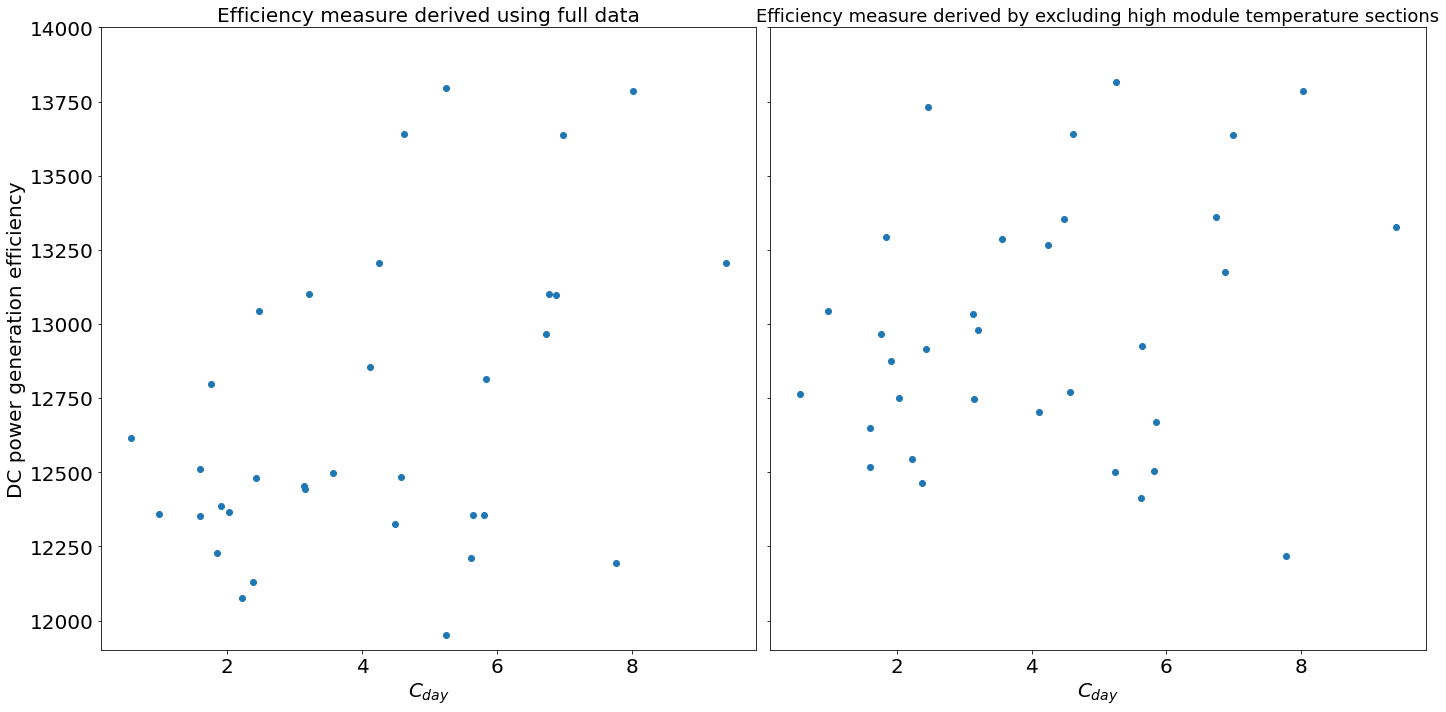

In [40]:
inv='1BY6WEcLGh8j5v7'
f, ax=plt.subplots(1,2, figsize=(20, 10), sharey=True)
ax[0].scatter(C_day['cloudiness'], conversion_data[conversion_data.Inverter==inv]['Conversion_coeff'], label="Efficiency measure using full data with the entire range of module temperatures")
ax[1].scatter(C_day['cloudiness'], conversion_data_lowT[conversion_data_lowT.Inverter==inv]['Conversion_coeff'], label="Efficiency measure using only low module temperature data")
ax[0].set_xlabel("$C_{day}$", fontsize=20)
ax[1].set_xlabel("$C_{day}$", fontsize=20)
ax[0].set_ylabel("DC power generation efficiency", fontsize=20)
ax[0].set_ylim(11900, 14000)
#ax[1].set_ylabel("DC power generation efficiency", fontsize=20)
ax[0].tick_params(labelsize=20)
ax[1].tick_params(labelsize=20)
ax[0].set_title("Efficiency measure derived using full data", fontsize=20)
ax[1].set_title("Efficiency measure derived by excluding high module temperature sections", fontsize=18)
plt.tight_layout()
#plt.xticks(fontsize=20)
#plt.yticks(fontsize=20)
#plt.legend()

(array([11500., 12000., 12500., 13000., 13500., 14000., 14500., 15000.,
        15500.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

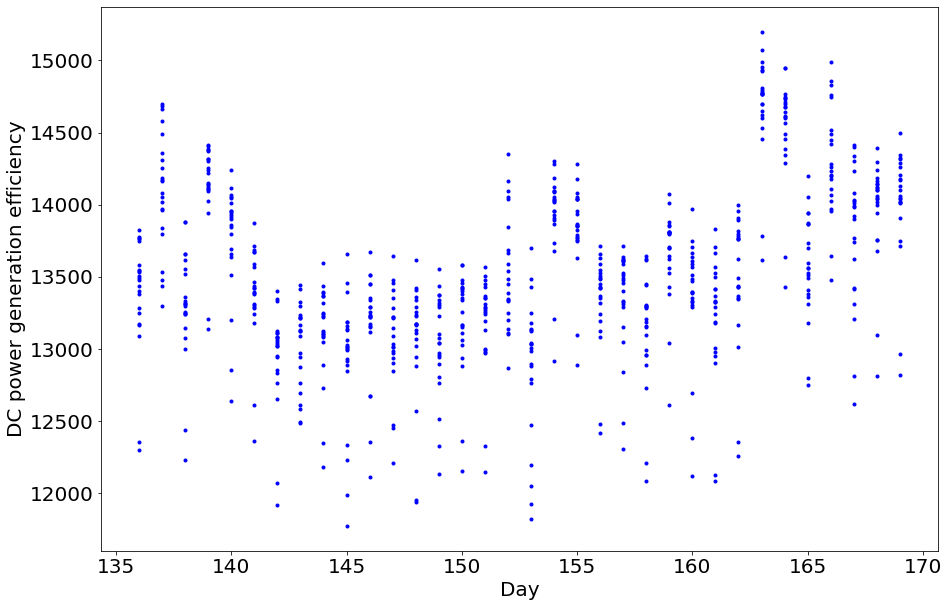

In [41]:
plt.figure(figsize=(15, 10))
for inv in conversion_data.Inverter.unique():
    plt.plot(conversion_data[conversion_data.Inverter==inv]['Day'], conversion_data[conversion_data.Inverter==inv]['Conversion_coeff'], 'b.', label=inv)
plt.xlabel('Day', fontsize=20)
plt.ylabel('DC power generation efficiency', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([11000., 12000., 13000., 14000., 15000., 16000., 17000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

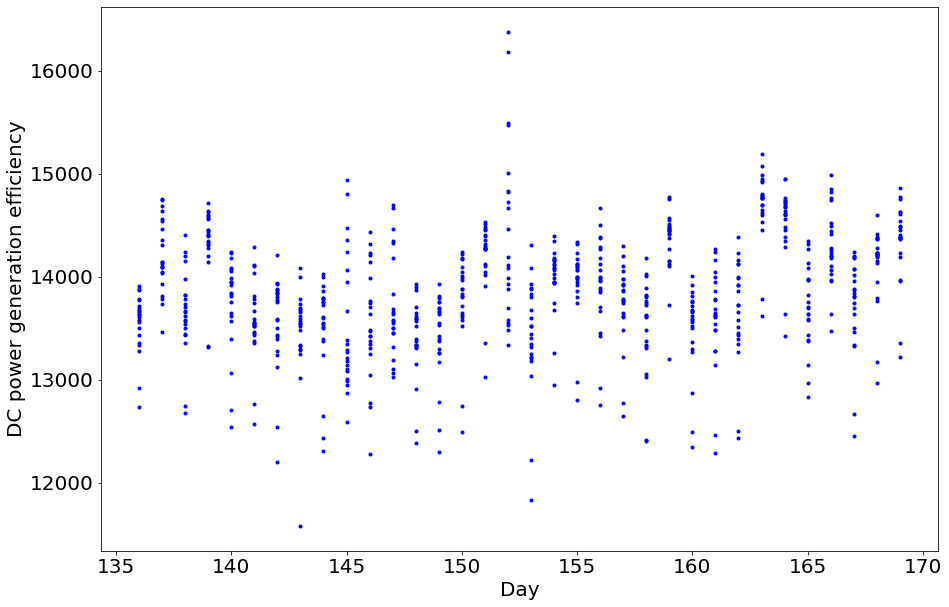

In [42]:
plt.figure(figsize=(15, 10))
for inv in conversion_data_lowT.Inverter.unique():
    plt.plot(conversion_data_lowT[conversion_data_lowT.Inverter==inv]['Day'], conversion_data_lowT[conversion_data_lowT.Inverter==inv]['Conversion_coeff'], 'b.', label=inv)
plt.xlabel('Day', fontsize=20)
plt.ylabel('DC power generation efficiency', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)